In [1]:
import numpy as np
import pandas as pd
from model.autoencoder import AutoEncoder
# from model.vae import aligned_vae, vae
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

import torch.optim as optim

import diffusion_dist as diff
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from dataset import *
import scipy
import math

from model.gae import gnn_vae, aligned_gvae, aligned_gae, GraphConvolutionSage

from torch.nn.parameter import Parameter


from model.loss import gae_loss, gvae_loss

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# # atac_dataset_diffmap = graphdata('./data/expr_atac_processed.csv', k = 20,  diff = "diffmap"# )
# rna_dataset_diffmap = graphdata('./data/expr_rna_processed.csv', k = 20, diff="diffma# p")
# torch.save(atac_dataset_diffmap, f= "./data/atac_diffmap# .pt")
# torch.save(rna_dataset_diffmap, f = "./data/rna_diffmap.pt")

atac_dataset_diffmap = torch.load(f = "./data/atac_diffmap.pt")
rna_dataset_diffmap = torch.load(f = "./data/rna_diffmap.pt")

In [3]:
# # atac_dataset_dpt = graphdata('./data/expr_atac_processed.csv', k = 20,  diff = "dpt"# )
# rna_dataset_dpt = graphdata('./data/expr_rna_processed.csv', k = 20, diff="dp# t")
# torch.save(atac_dataset_dpt, f = "./data/atac_dpt# .pt")
# torch.save(rna_dataset_dpt, f = "./data/rna_dpt.pt")

atac_dataset_dpt = torch.load(f = "./data/atac_dpt.pt")
rna_dataset_dpt = torch.load(f = "./data/rna_dpt.pt")

In [4]:
# atac_dataset_dpt = testgraphdata(None, 10)
# rna_dataset_dpt = testgraphdata(None, 10)

In [5]:
def mse_loss(latent1, latent2, adj1, adj2, recon_adj1, recon_adj2, lamb_align = 0.01):

    loss_align = lamb_align * torch.norm(latent1 - latent2, p = 'fro')
    
    
    adj1 = adj1 ** 2
    adj2 = adj2 ** 2
    adj1 = (adj1 / torch.norm(adj1, p = 'fro')) 
    adj2 = (adj2 / torch.norm(adj2, p = 'fro')) 
    recon_adj1 = (recon_adj1 / torch.norm(recon_adj1, p = "fro"))
    recon_adj2 = (recon_adj2 / torch.norm(recon_adj2, p = "fro")) 

    # mse approx, mse loss change sqrt with mean from norm loss, same
#     similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro") ** 2 / (adj1.shape[0] ** 2)
#     similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro") ** 2 / (adj2.shape[0] ** 2)
#     similarity_loss1_2 = F.mse_loss(adj1.reshape(1,-1), recon_adj1.reshape(1,-1), reduce="mean")
#     similarity_loss2_2 = F.mse_loss(adj2.reshape(1,-1), recon_adj2.reshape(1,-1), reduce="mean")
    
    similarity_loss1 = torch.norm(recon_adj1 - adj1, p = "fro")
    similarity_loss2 = torch.norm(recon_adj2 - adj2, p = "fro")
    
    loss = loss_align + similarity_loss1 + similarity_loss2 
    
    return loss, loss_align, similarity_loss1,  similarity_loss2

In [6]:
# use distance matrix

gae = aligned_gae(feature1_dim = rna_dataset_dpt['X'].shape[1], 
                  feature2_dim = atac_dataset_dpt['X'].shape[1], 
                  hidden_dim1 = 256, hidden_dim2 = , hidden_dim3 = 2, dropout = 0.)

# optimizer = optim.Adam(gae.parameters(), lr=1e-4, weight_decay=0.01)

optimizer = torch.optim.Adam(params=gae.parameters(), lr=1e-3, weight_decay=0.01)

# decayRate = 0.95
# lr_decay = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)

gae.train()
gae.reset_parameters()

In [ ]:
for epoch in range(0, 5000):

    optimizer.zero_grad()

    dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                       rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

    # loss, loss_align, loss_dist_atac,  loss_dist_rna = gae_loss(latent1 = latent_rna, latent2 = latent_atac, adj1 = rna_dataset_diffmap['adj'], adj2 = atac_dataset_diffmap['adj'], recon_adj1 = dist_rna, recon_adj2 = dist_atac, lamb_align = 1e-3, dist_loss_type = "mse")

    loss, loss_align, loss_dist_atac,  loss_dist_rna = mse_loss(latent1 = latent_rna, latent2 = latent_atac, 
                                                                adj1 = rna_dataset_dpt['adj'], 
                                                                adj2 = atac_dataset_dpt['adj'], 
                                                                recon_adj1 = dist_rna, recon_adj2 = dist_atac, 
                                                                lamb_align = 0.1)
    loss.backward()
    
    optimizer.step()

    # learning rate decay
    # lr_decay.step()

    if epoch % 10 == 0 or epoch == 0:
        log = "Epoch: {:03d}, Total loss: {:.5e}, loss align {:.5e}, Dist RNA loss {:.5e}, Dist ATAC loss {:.5e}"
        print(log.format(epoch, loss, loss_align, loss_dist_atac, loss_dist_rna))
        
        
    
    

Epoch: 000, Total loss: 6.74552e+00, loss align 3.98647e+00, Dist RNA loss 1.37702e+00, Dist ATAC loss 1.38203e+00
Epoch: 010, Total loss: 4.58105e+00, loss align 1.81636e+00, Dist RNA loss 1.38071e+00, Dist ATAC loss 1.38398e+00
Epoch: 020, Total loss: 3.24096e+00, loss align 4.87677e-01, Dist RNA loss 1.37911e+00, Dist ATAC loss 1.37417e+00
Epoch: 030, Total loss: 3.14956e+00, loss align 3.94615e-01, Dist RNA loss 1.37735e+00, Dist ATAC loss 1.37759e+00
Epoch: 040, Total loss: 2.96681e+00, loss align 2.16202e-01, Dist RNA loss 1.37661e+00, Dist ATAC loss 1.37400e+00
Epoch: 050, Total loss: 2.90099e+00, loss align 1.50217e-01, Dist RNA loss 1.37538e+00, Dist ATAC loss 1.37539e+00
Epoch: 060, Total loss: 2.87598e+00, loss align 1.29010e-01, Dist RNA loss 1.37424e+00, Dist ATAC loss 1.37273e+00
Epoch: 070, Total loss: 2.86632e+00, loss align 1.22652e-01, Dist RNA loss 1.37328e+00, Dist ATAC loss 1.37039e+00
Epoch: 080, Total loss: 2.85842e+00, loss align 1.17435e-01, Dist RNA loss 1.372

Epoch: 720, Total loss: 2.74238e+00, loss align 4.27100e-02, Dist RNA loss 1.36091e+00, Dist ATAC loss 1.33877e+00
Epoch: 730, Total loss: 2.72673e+00, loss align 2.91492e-02, Dist RNA loss 1.35869e+00, Dist ATAC loss 1.33888e+00
Epoch: 740, Total loss: 2.73141e+00, loss align 3.76747e-02, Dist RNA loss 1.35405e+00, Dist ATAC loss 1.33969e+00
Epoch: 750, Total loss: 2.72357e+00, loss align 3.10898e-02, Dist RNA loss 1.35342e+00, Dist ATAC loss 1.33906e+00
Epoch: 760, Total loss: 2.72152e+00, loss align 2.85911e-02, Dist RNA loss 1.35347e+00, Dist ATAC loss 1.33946e+00
Epoch: 770, Total loss: 2.72664e+00, loss align 2.99807e-02, Dist RNA loss 1.35833e+00, Dist ATAC loss 1.33833e+00
Epoch: 780, Total loss: 2.73310e+00, loss align 3.44850e-02, Dist RNA loss 1.36016e+00, Dist ATAC loss 1.33846e+00
Epoch: 790, Total loss: 2.73610e+00, loss align 4.28854e-02, Dist RNA loss 1.35462e+00, Dist ATAC loss 1.33859e+00
Epoch: 800, Total loss: 2.72462e+00, loss align 3.31705e-02, Dist RNA loss 1.353

Epoch: 1430, Total loss: 2.70297e+00, loss align 1.47152e-02, Dist RNA loss 1.35261e+00, Dist ATAC loss 1.33565e+00
Epoch: 1440, Total loss: 2.70246e+00, loss align 1.59233e-02, Dist RNA loss 1.35144e+00, Dist ATAC loss 1.33510e+00
Epoch: 1450, Total loss: 2.70266e+00, loss align 1.66628e-02, Dist RNA loss 1.35126e+00, Dist ATAC loss 1.33474e+00
Epoch: 1460, Total loss: 2.70296e+00, loss align 1.62233e-02, Dist RNA loss 1.35185e+00, Dist ATAC loss 1.33488e+00
Epoch: 1470, Total loss: 2.71282e+00, loss align 2.15851e-02, Dist RNA loss 1.35459e+00, Dist ATAC loss 1.33664e+00
Epoch: 1480, Total loss: 2.70897e+00, loss align 1.64077e-02, Dist RNA loss 1.35721e+00, Dist ATAC loss 1.33535e+00
Epoch: 1490, Total loss: 2.70605e+00, loss align 1.75198e-02, Dist RNA loss 1.35256e+00, Dist ATAC loss 1.33597e+00
Epoch: 1500, Total loss: 2.70072e+00, loss align 1.50380e-02, Dist RNA loss 1.35061e+00, Dist ATAC loss 1.33507e+00
Epoch: 1510, Total loss: 2.70496e+00, loss align 1.91489e-02, Dist RNA l

Epoch: 2140, Total loss: 2.70155e+00, loss align 1.60488e-02, Dist RNA loss 1.35099e+00, Dist ATAC loss 1.33452e+00
Epoch: 2150, Total loss: 2.70114e+00, loss align 1.64714e-02, Dist RNA loss 1.34959e+00, Dist ATAC loss 1.33508e+00
Epoch: 2160, Total loss: 2.69604e+00, loss align 1.30278e-02, Dist RNA loss 1.34850e+00, Dist ATAC loss 1.33452e+00
Epoch: 2170, Total loss: 2.69749e+00, loss align 1.53621e-02, Dist RNA loss 1.34818e+00, Dist ATAC loss 1.33394e+00
Epoch: 2180, Total loss: 2.70628e+00, loss align 2.35340e-02, Dist RNA loss 1.34788e+00, Dist ATAC loss 1.33486e+00
Epoch: 2190, Total loss: 2.70097e+00, loss align 1.81549e-02, Dist RNA loss 1.34838e+00, Dist ATAC loss 1.33443e+00
Epoch: 2200, Total loss: 2.69623e+00, loss align 1.19375e-02, Dist RNA loss 1.35011e+00, Dist ATAC loss 1.33418e+00
Epoch: 2210, Total loss: 2.71048e+00, loss align 1.34348e-02, Dist RNA loss 1.36164e+00, Dist ATAC loss 1.33541e+00
Epoch: 2220, Total loss: 2.70286e+00, loss align 1.52793e-02, Dist RNA l

Epoch: 2850, Total loss: 2.72263e+00, loss align 3.19545e-02, Dist RNA loss 1.35662e+00, Dist ATAC loss 1.33406e+00
Epoch: 2860, Total loss: 2.69642e+00, loss align 1.10604e-02, Dist RNA loss 1.35156e+00, Dist ATAC loss 1.33380e+00
Epoch: 2870, Total loss: 2.69090e+00, loss align 6.54132e-03, Dist RNA loss 1.35031e+00, Dist ATAC loss 1.33405e+00
Epoch: 2880, Total loss: 2.69088e+00, loss align 7.41724e-03, Dist RNA loss 1.34962e+00, Dist ATAC loss 1.33384e+00
Epoch: 2890, Total loss: 2.73815e+00, loss align 2.46229e-02, Dist RNA loss 1.37931e+00, Dist ATAC loss 1.33422e+00
Epoch: 2900, Total loss: 2.69248e+00, loss align 6.72081e-03, Dist RNA loss 1.35153e+00, Dist ATAC loss 1.33423e+00
Epoch: 2910, Total loss: 2.69864e+00, loss align 1.28195e-02, Dist RNA loss 1.35104e+00, Dist ATAC loss 1.33478e+00
Epoch: 2920, Total loss: 2.69540e+00, loss align 1.11201e-02, Dist RNA loss 1.35004e+00, Dist ATAC loss 1.33423e+00
Epoch: 2930, Total loss: 2.70664e+00, loss align 1.29550e-02, Dist RNA l

In [21]:
torch.save(gae.state_dict(), "gae_best.pth")

In [38]:
z1.shape

(2641, 2)

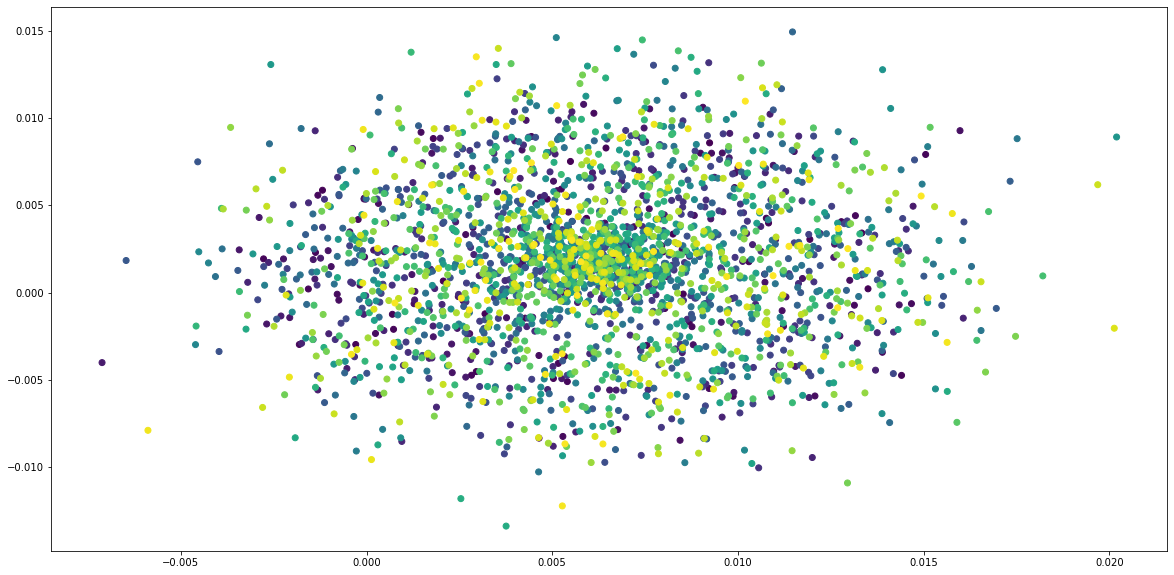

In [10]:
gae.eval()
dist_rna, dist_atac, latent_rna, latent_atac = gae(rna_dataset_dpt['X'], atac_dataset_dpt['X'], 
                                                   rna_dataset_dpt['similarity'], atac_dataset_dpt['similarity'])

z1 = latent_rna.detach().cpu().numpy()
z2 = latent_atac.detach().cpu().numpy()

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot()
ax.scatter(z1[:,0], z1[:,1], c = np.arange(rna_dataset_diffmap['X'].shape[0]))

In [33]:
np.unique(z2)

array([   0.     ,  699.4187 ,  858.73157, 2066.9932 ], dtype=float32)

In [26]:
np.linalg.norm(z2 - z1)

0.020515088